In [1]:
# importing libraries
import tensorflow  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt  
%matplotlib inline

In [2]:
import cv2
import os
import cv2 as cv

In [7]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (256,256))
        if img is not None:
            images.append(img)
    return images

In [8]:
folder= "C:/Users/anark/Downloads/seg_data/train_images"
images = load_images_from_folder(folder)
image_array = np.array(images)

In [9]:
folder= "C:/Users/anark/Downloads/seg_data/masks"
masks = load_images_from_folder(folder)
mask_array = np.array(masks)

### PreProcessing

Gamma Correction

In [ ]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)


# gamma_corrected = gammaCorrection(image_array[85],0.6)

def get_gamma_correction(image_array):
    total = image_array.shape[0]
    for i in range(0, total):
        image_array[i] = gammaCorrection(image_array[i],0.6)
    return image_array

image_array = get_gamma_correction(image_array)

CLAHE

In [ ]:
def CLAHE(image_array):

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    equalized = clahe.apply(gray_image_array)

    temp = np.zeros_like(image_array)
    temp[:,:,0] = equalized
    temp[:,:,1] = equalized
    temp[:,:,2] = equalized
    
    return temp

def get_clahe(image_array):
    total = image_array.shape[0]
    for i in range(0, total):
        image_array[i] = CLAHE(image_array[i])
    return image_array

image_array = get_clahe(image_array)

Remove Test Data

In [ ]:
test_images = image_array[2501:]
test_masks = mask_array[2501:]

for i in range(0,135):
    path_img = 'C:/Users/anark/Downloads/seg_data/test_images/img_' + str(i) + '.jpg'
    path_mask = 'C:/Users/anark/Downloads/seg_data/test_masks/img_' + str(i) + '.png'
    plt.imsave(path_img,test_images[i])
    plt.imsave(path_mask,test_masks[i])

### Data Augmentation

Noise

In [96]:
def noisy(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss":
        image=img.copy() 
        mean=0
        st=0.7
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(image,gauss)
        return image
    

# g_images = noisy(image_array[1303])

def Add_Noise(image_array, total_prop):
    img_count = image_array.shape[0]
    noise_added = []
    for i in range(0, total_prop):
        selected_image = random.randint(0,img_count)-1 
        image_array[selected_image] = noisy(image_array[selected_image])
        noise_added = noise_added + [selected_image]
    return image_array, noise_added

image_array,noise_added = Add_Noise(image_array,150)

Guassian Blur

In [108]:
def Add_Guassian_Blur(image_array, total_prop):
    img_count = image_array.shape[0]
    blur_added = []
    for i in range(0, total_prop):
        selected_image = random.randint(0,img_count)-1 
        image_array[selected_image] = cv2.GaussianBlur(image_array[selected_image],(13,13),cv2.BORDER_DEFAULT)
        blur_added = blur_added + [selected_image]
    return image_array, blur_added

image_array,blur_added = Add_Guassian_Blur(image_array,500)

Star Burst

In [ ]:
star_burst = cv2. imread(r"C:\Users\anark\Downloads\eye-ush-ritnet-857249c55bac\eye-ush-ritnet-857249c55bac\starburst_black.png")
gray = cv2.cvtColor(star_burst, cv2. COLOR_BGR2GRAY)

gray.shape

# https://stackoverflow.com/questions/14786179/how-to-convert-a-1-channel-image-into-a-3-channel-with-opencv2
img2 = np.zeros_like(image_array[0])
img2[:,:,0] = gray
img2[:,:,1] = gray
img2[:,:,2] = gray
img2.shape

plt.imshow(img2)

In [ ]:
def Add_Starburst(image_array, starburst, total_prop):
    img_count = image_array.shape[0]
    star_burst_added = []
    for i in range(0, total_prop):
        selected_image = random.randint(0,img_count) 
        image_array[selected_image] =  image_array[selected_image] + starburst
        star_burst_added = star_burst_added + [selected_image]
    return image_array, star_burst_added

In [ ]:
image_array,star_burst_added = Add_Starburst(image_array,img2,99)

Rotation & Translation

In [ ]:
def Rotate_Translate(image_array,mask_array,rotatation_angle=90,translation_rate = 15, total_prop = 10):
    img_count = image_array.shape[0]
    
    height, width = image_array[0].shape[:2]
    center = (width/2, height/2)
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle = rotatation_angle, scale=1)
    
    quarter_height, quarter_width = height / translation_rate, width / translation_rate
    T = np.float32([[1, 0, quarter_width], [0, 1, quarter_height]])
    
    rotation_added = []
    for i in range(0, total_prop):
        selected_image = random.randint(0,img_count) 
        
        image_array[selected_image] = cv2.warpAffine(src=image_array[selected_image], M=rotate_matrix, dsize=(width, height))
        mask_array[selected_image] = cv2.warpAffine(src=mask_array[selected_image], M=rotate_matrix, dsize=(width, height))
        rotation_added = rotation_added + [selected_image]

    translation_added = []
    for i in range(0, total_prop):
        selected_image = random.randint(0,img_count) 
        image_array[selected_image] = cv2.warpAffine(image_array[selected_image], T, (width, height))
        mask_array[selected_image] = cv2.warpAffine(mask_array[selected_image], T, (width, height))
        translation_added  = translation_added + [selected_image]
    
    return image_array, mask_array, rotation_added, translation_added

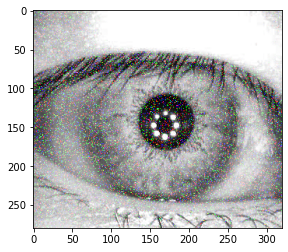

In [104]:
image_array, mask_array, rotation_added, translation_added = Rotate_Translate(image_array[0:2500],mask_array[0:2500],total_prop=250)

In [90]:
for i in range(0,2500):
    path_img = 'C:/Users/anark/Downloads/seg_data/train_images/img_' + str(i) + '.jpg'
    path_mask = 'C:/Users/anark/Downloads/seg_data/train_masks/img_' + str(i) + '.png'
    plt.imsave(path_img,image_array[i])
    plt.imsave(path_mask,mask_array[i])
    print(i+1)

Total Augmentation

In [129]:
len(noise_added) + len(blur_added) + len(star_burst_added) + len(rotation_added) + len(translation_added)

1250

Log Modifications

In [92]:
with open("C:/Users/anark/Downloads/seg_data/tranlation.txt", 'w') as file:
    for i in translation_added:
        file.write("%i\n" % i)


[1963,
 208,
 702,
 752,
 530,
 777,
 2345,
 364,
 202,
 2277,
 387,
 1634,
 471,
 1185,
 1284,
 1430,
 344,
 1563,
 2028,
 1719,
 987,
 1053,
 1013,
 1362,
 404,
 284,
 1767,
 2243,
 1580,
 456,
 1193,
 1772,
 1749,
 2440,
 783,
 416,
 2263,
 1056,
 1619,
 995,
 539,
 257,
 612,
 100,
 1560,
 347,
 1817,
 1631,
 804,
 943,
 2407,
 640,
 105,
 291,
 2281,
 1252,
 2003,
 14,
 492,
 1570,
 2167,
 1269,
 1280,
 724,
 1303,
 2069,
 1951,
 2080,
 1495,
 1663,
 1801,
 1658,
 1932,
 1952,
 129,
 329,
 2476,
 2203,
 1239,
 1352,
 1383,
 535,
 1192,
 2003,
 563,
 1406,
 34,
 39,
 1828,
 278,
 1037,
 128,
 2363,
 2363,
 2221,
 868,
 1854,
 1429,
 880,
 33,
 1944,
 1762,
 269,
 2310,
 2206,
 1960,
 2151,
 314,
 2023,
 2354,
 1879,
 2477,
 918,
 855,
 49,
 2285,
 1730,
 2169,
 823,
 960,
 1140,
 274,
 2152,
 1548,
 939,
 695,
 1647,
 2243,
 1994,
 1971,
 2451,
 1713,
 222,
 2048,
 177,
 1406,
 557,
 1056,
 2344,
 2317,
 11,
 749,
 1100,
 374,
 1494,
 807,
 1628,
 1301,
 1887,
 1311,
 2011,
 1733,


Images

Blur

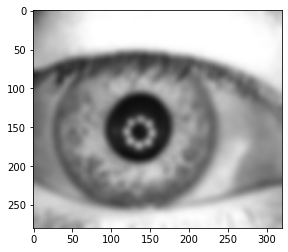

In [130]:
plt.imshow(image_array[1303])

Starburst

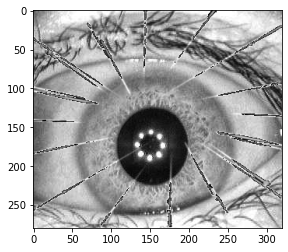

In [87]:
plt.imshow(image_array[191])

CLAHE

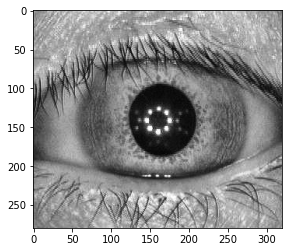

In [22]:
plt.imshow(clahe_image_798)

Gamma Correction

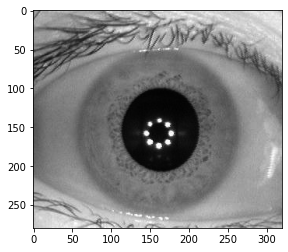

In [17]:
plt.imshow(image_array[85])

Rotation

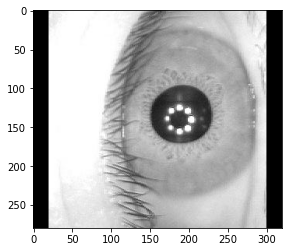

In [339]:
plt.imshow(image_array[2279])

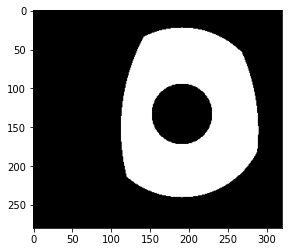

In [340]:
plt.imshow(mask_array[2279])

Translation

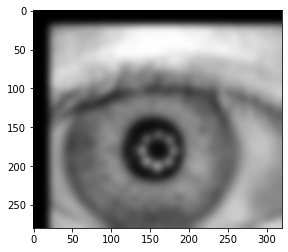

In [139]:
plt.imshow(image_array[789])

SuperImposition

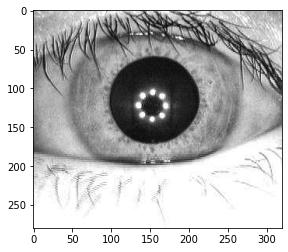

In [135]:
plt.imshow(image_array[0])

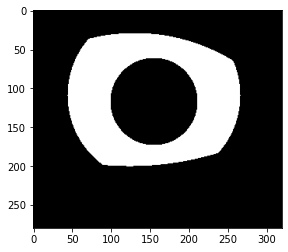

In [136]:
plt.imshow(mask_array[0])

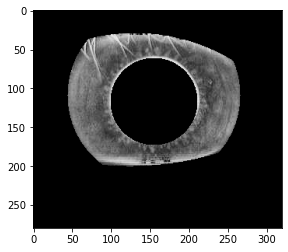

In [138]:
plt.imshow(mask_array[0]*image_array[0])

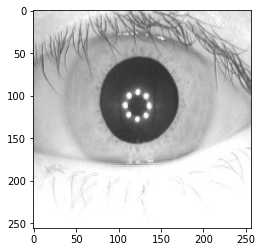

In [10]:
plt.imshow(image_array[0])

In [74]:
#Step 4: Define Dice Loss
# https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
    
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1],np.float32)
    y_pred_f = tf.reshape(y_pred, [-1],np.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [51]:
np

<module 'numpy' from 'C:\\Users\\anark\\AppData\\Roaming\\Python\\Python38\\site-packages\\numpy\\__init__.py'>

In [52]:
y_true = image_array[0].astype(np.float32)
y_true.dtype

dtype('float32')

In [42]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
import numpy as np

In [69]:

y_true = mask_array[58].astype(np.float32)
y_pred = mask_array[100].astype(np.float32)
    
y_true_f = tf.reshape(y_true, [-1], np.float32)
y_pred_f = tf.reshape(y_pred, [-1], np.float32)
intersection = tf.reduce_sum(y_true_f * y_pred_f)
score = (2 * intersection + 1) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1)
score

<tf.Tensor: shape=(), dtype=float32, numpy=219.4623>

In [70]:
smooth = 1
y_true = mask_array[58].astype(np.float32)
y_pred = mask_array[100].astype(np.float32)
# Flatten
y_true_f = tf.reshape(y_true, [-1],np.float32)
y_pred_f = tf.reshape(y_pred, [-1],np.float32)
intersection = tf.reduce_sum(y_true_f * y_pred_f)
score = (2 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [77]:
bce_dice_loss(mask_array[20].astype(np.float32), mask_array[0].astype(np.float32))

<tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[-115.702805, -115.702805, -115.702805, ..., -115.702805,
        -115.702805, -115.702805],
       [-115.702805, -115.702805, -115.702805, ..., -115.702805,
        -115.702805, -115.702805],
       [-115.702805, -115.702805, -115.702805, ..., -115.702805,
        -115.702805, -115.702805],
       ...,
       [-115.702805, -115.702805, -115.702805, ..., -115.702805,
        -115.702805, -115.702805],
       [-115.702805, -115.702805, -115.702805, ..., -115.702805,
        -115.702805, -115.702805],
       [-115.702805, -115.702805, -115.702805, ..., -115.702805,
        -115.702805, -115.702805]], dtype=float32)>

<tf.Tensor: shape=(), dtype=float32, numpy=204.29982>